In [1]:
import tensorflow as tf
print(tf.__version__)
tf.config.list_physical_devices()

2.4.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
train_data_directory = 'D:/data science/cats and dogs/train/'

image_size = (299,299)

In [3]:
# image data preprocessing
batch_size = 32


class_mode = 'categorical' # for multi-class classification problem, use: class_mode = 'category' 


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2 # set validation split
    ) 

train_generator = train_datagen.flow_from_directory(
    train_data_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=class_mode, # for multi-class classification problem, use 'category'
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_directory, # same directory as training data
    target_size=image_size,
    batch_size=batch_size,
    class_mode=class_mode, # for multi-class classification problem, use 'category'
    subset='validation') # set as validation data

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [4]:
# build a model
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

base_model.trainable = False

# Create the model
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 262146    
Total params: 22,064,930
Trainable params: 262,146
Non-trainable params: 21,802,784
_________________________________________________________________


In [5]:
# compile model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.01),
              metrics=['acc'])

In [6]:
# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("InceptionV3_dogs_vs_cats.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq='epoch')
early = tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
                      min_delta=0, 
                      patience=5, 
                      verbose=1, 
                      mode='auto')
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                            patience=1,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.0000001)

In [7]:
# fit/train model

nb_epochs = 1000

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=[checkpoint, early, learning_rate_reduction])

Epoch 1/1000
625/625 [==============================] - 409s 635ms/step - loss: 15.1018 - acc: 0.9240 - val_loss: 52.9690 - val_acc: 0.8828

Epoch 00001: val_acc improved from -inf to 0.88281, saving model to InceptionV3_dogs_vs_cats.h5
Epoch 2/1000
625/625 [==============================] - 389s 623ms/step - loss: 16.1058 - acc: 0.9595 - val_loss: 16.7237 - val_acc: 0.9547

Epoch 00002: val_acc improved from 0.88281 to 0.95473, saving model to InceptionV3_dogs_vs_cats.h5
Epoch 3/1000
625/625 [==============================] - 390s 624ms/step - loss: 18.8784 - acc: 0.9549 - val_loss: 24.2465 - val_acc: 0.9537

Epoch 00003: val_acc did not improve from 0.95473

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 4/1000
625/625 [==============================] - 390s 625ms/step - loss: 13.5788 - acc: 0.9686 - val_loss: 14.1763 - val_acc: 0.9649

Epoch 00004: val_acc improved from 0.95473 to 0.96494, saving model to InceptionV3_dogs_vs_cats.h5
Epoch 5/100

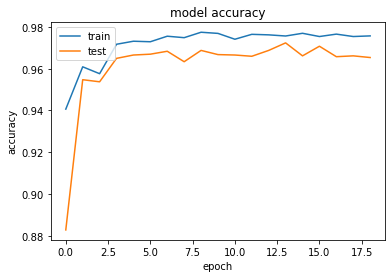

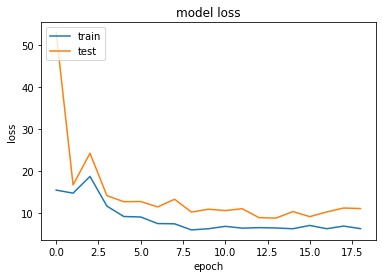

In [8]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()